In [1]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams["figure.facecolor"] = "green"
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_diabetes

In [2]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=42)

#### 1. Задание.

- Для реализованной в методичке модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом. 
- Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев). 
- Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).

In [3]:
def gb_predict(X, trees, coefs, eta):
    return np.array([sum([eta * coef * alg.predict([x])[0] for coef, alg in zip(coefs, trees)]) for x in X])

def mean_squared_error(y_actual, y_pred):
    return sum((y_actual - y_pred) ** 2) / len(y_actual)

def gb_bias(y, z):
    return -2 * (z - y)

def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    trees = []
    train_errs = []
    test_errs = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        if len(trees) == 0:
            train_errs.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errs.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
            tree.fit(X_train, y_train)
        else:
            z_train = gb_predict(X_train, trees, coefs, eta)
            bias = gb_bias(y_train, z_train)
            tree.fit(X_train, bias)
            train_errs.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errs.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        trees.append(tree)
    return trees, train_errs, test_errs

In [4]:
n_trees = 10
coefs = [1] * n_trees
eta_list = np.logspace(np.log10(.5), np.log10(.005), num=6)
max_depth = 3

train_errs_per_eta = []
test_errs_per_eta = []

for eta in eta_list:
    trees, train_errs, test_errs = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_errs_per_eta.append(train_errs)
    test_errs_per_eta.append(test_errs)

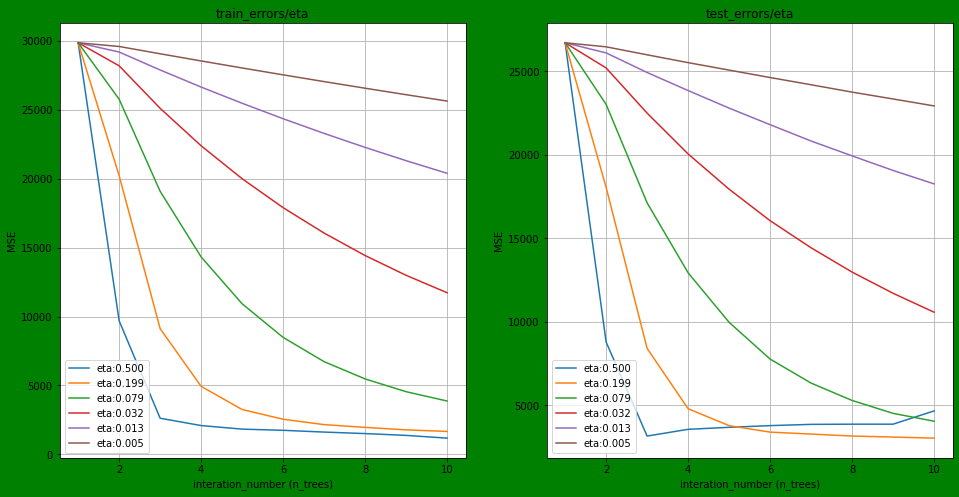

In [5]:
plt.figure(figsize=(16,8))

plt.subplot(121)
plt.title("train_errors/eta")
plt.xlabel("interation_number (n_trees)")
plt.ylabel("MSE")
for num, err_list in enumerate(train_errs_per_eta):
    plt.plot(list(range(1, len(err_list)+1)), err_list, label=f"eta:{eta_list[num]:.3f}")
plt.grid()
plt.legend()

plt.subplot(122)
plt.title("test_errors/eta")
plt.xlabel("interation_number (n_trees)")
plt.ylabel("MSE")
for num, err_list in enumerate(test_errs_per_eta):
    plt.plot(list(range(1, len(err_list)+1)), err_list, label=f"eta:{eta_list[num]:.3f}")
plt.grid()
plt.legend() #loc="upper right")

plt.show()

In [6]:
n_trees = 10
coefs = [1] * n_trees
eta = .2
# eta_list = np.logspace(np.log10(.5), np.log10(.005), num=6)
depth_list = [1, 2, 3, 5, 8, 12]

train_errs_per_depth = []
test_errs_per_depth = []

for max_depth in depth_list:
    trees, train_errs, test_errs = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta)
    train_errs_per_depth.append(train_errs)
    test_errs_per_depth.append(test_errs)

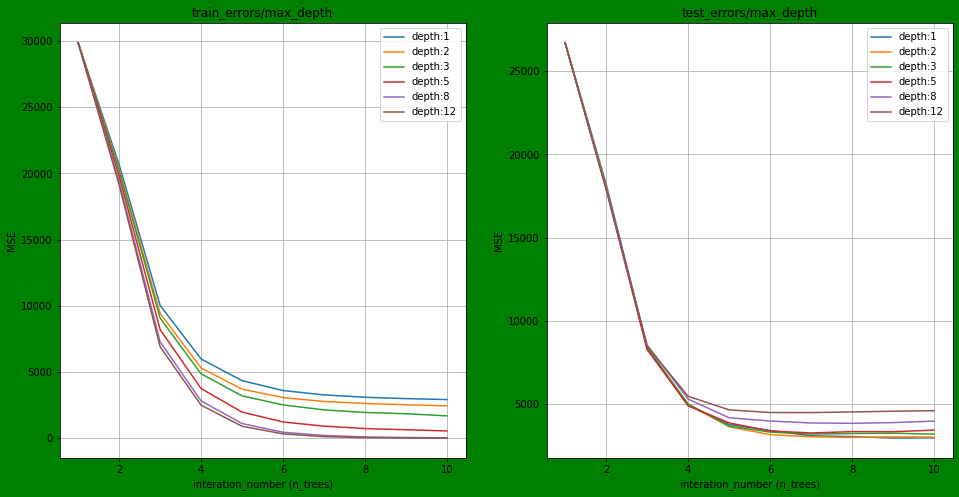

In [7]:
plt.figure(figsize=(16,8))

plt.subplot(121)
plt.title("train_errors/max_depth")
plt.xlabel("interation_number (n_trees)")
plt.ylabel("MSE")
for num, err_list in enumerate(train_errs_per_depth):
    plt.plot(list(range(1, len(err_list)+1)), err_list, label=f"depth:{depth_list[num]}")
plt.grid()
plt.legend()

plt.subplot(122)
plt.title("test_errors/max_depth")
plt.xlabel("interation_number (n_trees)")
plt.ylabel("MSE")
for num, err_list in enumerate(test_errs_per_depth):
    plt.plot(list(range(1, len(err_list)+1)), err_list, label=f"depth:{depth_list[num]}")
plt.grid()
plt.legend() #loc="upper right")

plt.show()

In [8]:
print(f"{[round(errs[9]) for errs in train_errs_per_depth]}\n"
      f"{[round(errs[9]) for errs in test_errs_per_depth]}")

[2917, 2442, 1688, 550, 26, 5]
[2947, 2996, 3175, 3416, 3959, 4584]


In [9]:
%%time
# n_trees = 6
# max_depth = 2
# eta = .2
trees, train_errs, test_errs = gb_fit(6, 2, X_train, X_test, y_train, y_test, coefs, .2)
print(f"Оптимальные гиперпараметры: n_trees=6, max_depth=2, eta=.2\n"
      f"MSE_train: {round(train_errs[5],-2):.0f}, MSE_test: {round(test_errs[5],-2):.0f}")

Оптимальные гиперпараметры: n_trees=6, max_depth=2, eta=.2
MSE_train: 3100, MSE_test: 3100
Wall time: 462 ms


#### Выводы:
1. Шаг градиента $\eta$. Очевидно, что при низком значении шага градиента происходит очень медленное продвижение к минимуму ошибки. При значениях ниже $\approx .1$ - 10 итераций (10 деревьев в ансамбле) недостаточно чтобы выйти на минимум ошибки. Использование шага в таком диапазоне будет лишь потреблять вычислительные мощности не давая ничего взамен. 

    Значение шага градинета равное $\eta=.5$ явно велико, т.к. на тесте видно что вначале итераций ошибка падает, а в конце немного растет - это указывает на то, что мы перескочили точку минимума ошибки.

    Оптимальное значение шага градиента находится в диапазоне от $\eta <.5$ до $\eta>\approx.1$, т.е. $\eta \in (.1\ ; .5)$; Я выбрал значение $\eta=.2$; при таком значении видно, что ошибка уверенно снижается и "ложится" на ассимптоту - далее почти горизонтальна!

2. Далее максимальная глубина деревьев. Здесь получилось очень интересно. С увеличением глубины деревьев ошибка модели уменьшается и становится меньше на traine, т.е. модель вроде как становится точнее. Однако на teste картина не то, что другая, а прямо противоположная - ошибка на teste растет с увеличением глубины деревьев. Это указвает явно на переобучение. Лучшие метрики на teste получились с минимальной глубиной дерева, т.е. практически с пнями ))) Я выбрал значение max_depth=2;

3. Количество итераций (оно же количество деревьев в ансамбле). Мне очевидно, что этот параметр логично было бы настраивать последним, т.к. при некоторых значениях, например $\eta<.05$, количество итераций будет недостаточно; при других значениях, например max_depth= 1, 2, 3, количество итераций можно уменьшить.

---
+ Оптимальные гиперпараметры без переобучения: n_trees=6, max_depth=2, eta=.2, MSE_train: 3100, MSE_test: 3100;

<!-- lorem ipsum dolor sit amet... -->

<font color="red">Я переносил код из урока не копированием_вставкой, а по памяти, и в процессе отладки у меня возник вопрос.</font>

<font color="red">В функции `gb_fit()` на каждой итерации цикла мы создавали новый объект дерева (очередной алгоритм в ансамбле) с одинаковыми гиперпараметрами, а потом обучали его на новых данных... Все логично.</font>

<font color="red">Я подумал, а зачем нам каждый раз пересоздавать объект дерева: `tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)` если его гиперпараметры не меняются. Я попробовал создать объект один раз за пределами цикла и на каждой итерации просто переобучать его, складывая в список копии по сути одного объекта дерева, но обученного на разных данных. Но к сожалению, алгоритм начал выдавать ошбику.</font>

<font color="red">Я не понял как в таком случае работает объектная модель в `sklearn`. Я думал, что на этапе созднаия объекта - создаются его атрибуты связанные с гиперпараметрами. А на этапе обученя (после вызова метода `fit()`) добавляются атрибуты связанные с параметрами; логично было бы, что если вызвать еще раз метод `fit()` и передать ему другие данные, то атрибуты связанные с параметрами у объекта перезапишутся. Но почему то это не действует.</font>

<font color="red">Можете мне ответить в чём я не прав и какая логика действует в `sklearn`?</font>

#### 2. (\*) Задание.

Модифицировать реализованный алгоритм, чтобы получился стохастический градиентный бустинг. Размер подвыборки принять равным 0.5.    Сравнить на одном графике кривые  изменения ошибки на тестовой выборке в зависимости от  числа итераций.

In [10]:
"""def gb_predict(X, trees, coefs, eta):
    return np.array([sum([eta * coef * alg.predict([x])[0] for coef, alg in zip(coefs, trees)]) for x in X])

def mean_squared_error(y_actual, y_pred):
    return sum((y_actual - y_pred) ** 2) / len(y_actual)

def gb_bias(y, z):
    return -2 * (z - y)
"""

import random

def sgb_fit(X_train, X_test, y_train, y_test, n_trees=6, max_depth=2, eta=.2, coefs=[1]*10):
    trees = []
    train_errs = []
    test_errs = []
    
    for i in range(n_trees):
        random.seed(28)
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        if len(trees) == 0:
            train_errs.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errs.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
            
            smpl_ind = random.sample(range(X_train.shape[0]), k=int(X_train.shape[0]/2))
            tree.fit(X_train[smpl_ind], y_train[smpl_ind])
        else:
            z_train = gb_predict(X_train, trees, coefs, eta)
            bias = gb_bias(y_train, z_train)
            
            smpl_ind = random.sample(range(X_train.shape[0]), k=int(X_train.shape[0]/2))
            tree.fit(X_train[smpl_ind], bias[smpl_ind])
            
            train_errs.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errs.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        trees.append(tree)
    return trees, train_errs, test_errs

In [11]:
trees, stochastic_train_errs, stochastic_test_errs = sgb_fit(X_train, X_test, y_train, y_test, n_trees=10)
print(f"Ошибка на train: {[int(err) for err in stochastic_train_errs]}\n"
      f"Ошибка на teste: {[int(err) for err in stochastic_test_errs]}")

Ошибка на train: [29866, 20079, 9073, 5121, 3664, 3088, 2877, 2795, 2742, 2697]
Ошибка на teste: [26711, 17707, 8201, 4654, 3343, 2919, 2848, 2737, 2737, 2771]


In [12]:
ensemble, train_errs, test_errs = gb_fit(10, 2, X_train, X_test, y_train, y_test, [1]*10, .2)
print(f"Ошибка на train: {[int(err) for err in train_errs]}\n"
      f"Ошибка на teste: {[int(err) for err in test_errs]}")

Ошибка на train: [29866, 20337, 9427, 5296, 3705, 3067, 2772, 2621, 2526, 2442]
Ошибка на teste: [26711, 18097, 8302, 4962, 3617, 3142, 3016, 2976, 3012, 2995]


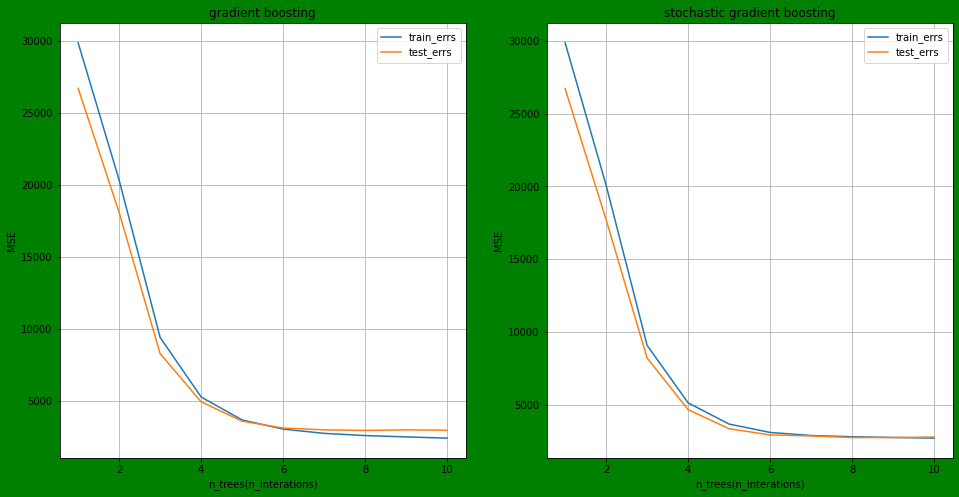

In [13]:
plt.figure(figsize=(16, 8))
plt.subplot(122)
plt.title("stochastic gradient boosting")
plt.xlabel("n_trees(n_interations)")
plt.ylabel("MSE")
plt.plot([*range(1, len(trees)+1)], stochastic_train_errs, label="train_errs")
plt.plot([*range(1, len(trees)+1)], stochastic_test_errs, label="test_errs")
plt.legend()
plt.grid()

plt.subplot(121)
plt.title("gradient boosting")
plt.xlabel("n_trees(n_interations)")
plt.ylabel("MSE")
plt.plot([*range(1, len(trees)+1)], train_errs, label="train_errs")
plt.plot([*range(1, len(trees)+1)], test_errs, label="test_errs")
plt.legend()
plt.grid()

plt.show()

#### Задание (2). Выводы:
Во-первых, очевидно, что стохастический бустинг ничем не уступает обычному, а в скорости и потреблении вычислительной мощности выигрывает. 

Во-вторых, выполняя серию реализаций стохастического бустинга я заметил, что зачастую он быстрее достигает оптимального обучения (меньше нужно деревьев, меньше шагов). И динамика ошибок стохастического градиентного бустинга более стабильная; ошибка быстрее "выходит на ассимптоту" не переобучаясь.

#### Задание 3. (\*)

Модифицировать алгоритм градиентного бустинга, взяв за основу реализацию решающего дерева из ДЗ_4 (для задачи регрессии). Сделать выводы о качестве алгоритма по сравнению с реализацией из п.1.

In [14]:
class my_DecisionTreeRegressor:
    
    def __init__(self, criterion="mse", min_samples_leaf=1, max_leaf_nodes=None):
        self.criterion = criterion
        self.min_samples_leaf = min_samples_leaf
        self.max_leaf_nodes = max_leaf_nodes
        
    def reg_fit(self, X, y, max_depth=None):
        self.max_depth = max_depth
        depth = 0
        quality, t, index = Node_reg.reg_find_best_split(self, X, y)
        if (t is None) or (index is None):
            return Leaf_reg(X, y)
        true_X, false_X, true_y, false_y = Node_reg.reg_split(X, y, index, t)
        if ((len(true_X) <= self.min_samples_leaf) or (len(false_X) <= self.min_samples_leaf)) \
                                                   and (depth != 0):
            return Leaf_reg(X, y)
        if max_depth is not None:
            if max_depth != 0:
                max_d = max_depth - 1
                depth += 1
                true_branch = my_DecisionTreeRegressor.reg_fit(self, true_X, true_y, max_depth=max_d)
                false_branch = my_DecisionTreeRegressor.reg_fit(self, false_X, false_y, max_depth=max_d)
            else:
                return Leaf_reg(X, y)
        else:
            depth += 1
            true_branch = my_DecisionTreeRegressor.reg_fit(self, true_X, true_y)
            false_branch = my_DecisionTreeRegressor.reg_fit(self, false_X, false_y)
        self.reg_dtree = Node_reg(index, t, true_branch, false_branch)
        return self.reg_dtree
    
    @staticmethod
    def predict_obj(obj, node):
        if isinstance(node, Leaf_reg):
            answer = node.pred_value
            return answer
        if obj[node.index] <= node.t:
            return my_DecisionTreeRegressor.predict_obj(obj, node.true_branch)
        else:
            return my_DecisionTreeRegressor.predict_obj(obj, node.false_branch)
    
    @staticmethod
    def reg_predict(tree, X):
        pred_vec = []
        for obj in X:
            pred_val = my_DecisionTreeRegressor.predict_obj(obj, tree)
            pred_vec.append(pred_val)
        return pred_vec

    
######    
class Leaf_reg:
    def __init__(self, X, y):
        self.feat_values = X
        self.targ_values = y
        self.pred_value = np.mean(self.targ_values)


######    
class Node_reg:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index
        self.t = t
        self.true_branch = true_branch
        self.false_branch = false_branch

    @staticmethod
    def reg_quality(targ_val_l, targ_val_r, disp_curr):
        disp_left = np.var(targ_val_l)
        disp_righ = np.var(targ_val_r)
        weig = float(targ_val_l.shape[0]) / (targ_val_l.shape[0] + targ_val_r.shape[0])
        return disp_curr - weig * disp_left - (1 - weig) * disp_righ
    
    @staticmethod
    def reg_split(X, y, index, t):
        left = np.where(X[:, index] <= t)
        right = np.where(X[:, index] > t)
        true_X = X[left]
        false_X = X[right]
        true_y = y[left]
        false_y = y[right]
        return true_X, false_X, true_y, false_y
    
    def reg_find_best_split(self, X, y):
        disp_curr = np.var(y)
        best_quality = 0
        best_t = None
        best_index = None
        n_features = X.shape[1]
        for index in range(n_features):
            t_values = np.unique([row[index] for row in X])
            for t in t_values:
                true_X, false_X, true_y, false_y = Node_reg.reg_split(X, y, index, t)
                if len(true_X) < self.min_samples_leaf or len(false_X) < self.min_samples_leaf:
                    continue
                current_quality = Node_reg.reg_quality(true_y, false_y, disp_curr)
                if current_quality > best_quality:
                    best_quality, best_t, best_index = current_quality, t, index
        return best_quality, best_t, best_index

    @staticmethod
    def mse_metric(actual, predicted):
        return np.mean((actual - predicted) ** 2)
    

######
class ColorText:
    PURPLE = '\033[1;35;48m'
    CYAN = '\033[1;36;48m'
    BOLD = '\033[1;39;48m'
    GREEN = '\033[1;34;48m'
    BLUE = '\033[1;44;48m'
    ORANGE = '\033[1;32;48m'
    YELLOW = '\033[1;33;48m'
    RED = '\033[1;31;48m'
    BLACK = '\033[1;30;48m'
    UNDERLINE = '\033[1;37;48m'
    END = '\033[1;37;0m'

def reg_print_tree(node, spacing=""):
    if isinstance(node, Leaf_reg):
        print(ColorText.ORANGE + spacing + ' ЛИСТ' 
                  + ': прогноз = ' + str(node.pred_value) 
                  + ', объектов = ' + str(len(node.targ_values)) 
                  + ColorText.END)
        return
    print(ColorText.GREEN + spacing + 'УЗЕЛ'  
              + ': индекс = ' + str(node.index) 
              + ', порог = ' + str(round(node.t, 2))
              + ColorText.END)
    print (spacing + '--> Левая ветка:')
    reg_print_tree(node.true_branch, spacing + "   ")
    print (spacing + '--> Правая ветка:')
    reg_print_tree(node.false_branch, spacing + "   ")

In [15]:
def gb_predict_my_reg(X, ensemble, coefs, eta):
    pred_vec = []
    for obj in X:
        pred_obj = 0
        for tree, coef in zip(ensemble, coefs):
            pred_obj += my_DecisionTreeRegressor.predict_obj(obj, tree) * coef * eta
        pred_vec.append(pred_obj)
    return np.array(pred_vec)

def gb_predict_my_reg2(X, ensemble, coefs, eta):
    pred_vec = []
    for tree, coef in zip(ensemble, coefs):
        pred_tree = [val * coef * eta for val in my_DecisionTreeRegressor.reg_predict(tree, X)]
        pred_vec.append(pred_tree)
    return np.sum(pred_vec, axis=0) if pred_vec else [0] * len(X)

def gb_fit_my_reg(n_trees, max_depth, X_train, X_test, y_train, y_test, coefs, eta):
    ensemble = []
    train_errs = []
    test_errs = []
    
    for i in range(n_trees):
        my_reg_alg = my_DecisionTreeRegressor()
        
        if len(ensemble) == 0:
            train_pred = gb_predict_my_reg2(X_train, ensemble, coefs, eta)
            test_pred = gb_predict_my_reg2(X_test, ensemble, coefs, eta)
            
            train_errs.append(Node_reg.mse_metric(y_train, train_pred))
            test_errs.append(Node_reg.mse_metric(y_test, test_pred))
            
            my_reg_alg.reg_fit(X_train, y_train, max_depth=max_depth)
        else:
            z_train = gb_predict_my_reg2(X_train, ensemble, coefs, eta)
            bias = gb_bias(y_train, z_train)
            my_reg_alg.reg_fit(X_train, bias, max_depth=max_depth)
            
            train_pred = gb_predict_my_reg2(X_train, ensemble, coefs, eta)
            test_pred = gb_predict_my_reg2(X_test, ensemble, coefs, eta)

            train_errs.append(Node_reg.mse_metric(y_train, train_pred))
            test_errs.append(Node_reg.mse_metric(y_test, test_pred))
        
        ensemble.append(my_reg_alg.reg_dtree)
    return ensemble, train_errs, test_errs

In [16]:
%%time
ensemble, train_errs, test_errs = gb_fit_my_reg(12, 2, X_train, X_test, y_train, y_test, [1]*12, .2)

Wall time: 2.36 s


In [17]:
print("Results for gb_predict_my_reg2():\n")
print(f"{[round(err) for err in train_errs]}\n"
      f"{[round(err) for err in test_errs]}\n"
      f"len_errors: {len(train_errs)}")

Results for gb_predict_my_reg2():

[29867, 20338, 9427, 5296, 3705, 3068, 2773, 2621, 2527, 2442, 2338, 2297]
[26712, 18097, 8302, 4962, 3618, 3143, 3016, 2977, 3012, 2996, 2970, 3008]
len_errors: 12


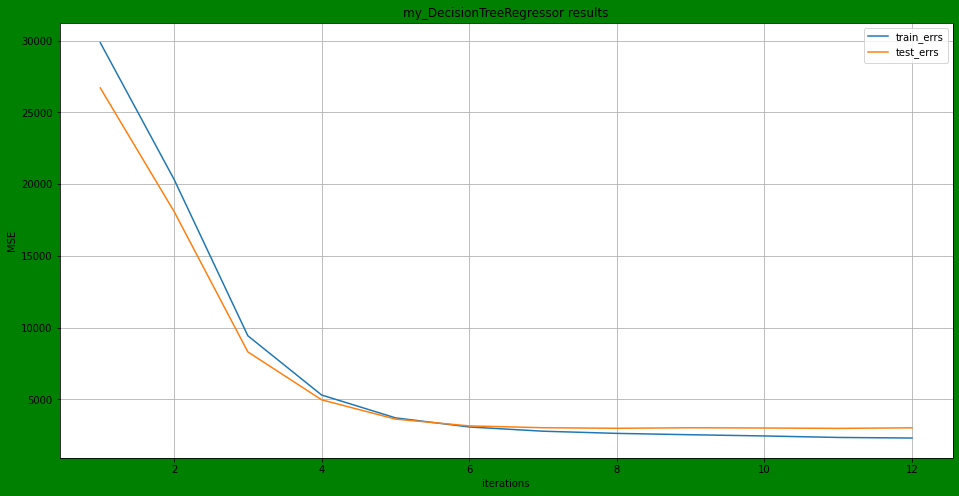

In [18]:
plt.figure(figsize=(16,8))

plt.plot([*range(1, len(train_errs) + 1)], train_errs, label="train_errs")
plt.plot([*range(1, len(test_errs) + 1)], test_errs, label="test_errs")

plt.title("my_DecisionTreeRegressor results")
plt.xlabel("iterations")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()

#### Results for gb_predict_my_reg2():

---
[29867, 20182, 9070, 4861, 3194, 2514, 2138, 1944, 1847, 1688, 1589, 1513, 1432, 1334, 1277, 1256, 1184, 1119, 1063, 1034]

[26712, 18016, 8331, 4899, 3601, 3243, 3127, 3159, 3178, 3128, 3105, 3075, 3148, 3167, 3272, 3332, 3340, 3284, 3306, 3302]

len_errors: 20

#### Results for gb_predict_my_reg():

---
[29867, 20338, 9427, 5296, 3705, 3068]

[26712, 18097, 8302, 4962, 3618, 3143]

#### Results for gb_predict_my_reg2():

---
[29867, 20338, 9427, 5296, 3705, 3068]

[26712, 18097, 8302, 4962, 3618, 3143]

#### Задание 3. Выводы: 

Главный вывод по 3-му заданию в том, что дебажить в jupyter notebook это сущее проклятие!
на каком-то эпате оказывалось, что дерево создавалось из единственного листа и это вызывало ошибку, найти её и исправить было очень тяжело))) 

В бою, надеюсь, будет легче)

Если говорить о сравниваемых алгоритмах. Первый из scikit-learn, второй самодельный. Оба показали близкие результаты (минимальная ошибка на тесте у scikit-learn: 3100; у самодельного тоже 2977); Поведение кривых (train-test) похожи, гиперпараметры подобраны схожие. Правда скорость работу у sklearn в 5 раз быстрее.

### Что касается производной.

В лекции утверждается что производная функции потерь вида:
$$L(y, z) = \log(1 + exp(-yz))$$
является 
$$L'(y, z) = \frac{y}{1+\exp(-yz)}.$$


Что получается у меня (предполагается что логарифм натуральный т.е. $ln()$
$$\frac{dL}{dz}=\log_e\big(1+\exp(-yz)\big)'=\frac{1}{1+\exp(-yz)}\cdot \big(1+\exp(-yz)\big)'= \frac{1}{1+\exp(-yz)}\cdot \exp(-yz)\cdot (-yz)'= \frac{1}{1+\exp(-yz)}\cdot \exp(-yz)\cdot (-y) = \frac{-y\cdot \exp(-yz)}{1+\exp(-yz)} = \frac{-y}{1+\exp(yz)}.$$

Как-то так. Разве я не прав?